In [5]:
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from torch import nn
from torch.optim import Adam


In [6]:
import torch
data = pd.read_csv("train.csv")
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]
Scaler = MinMaxScaler()
train_GHI = train["Clearsky GHI"].values
train.drop(["Clearsky GHI"],axis=1,inplace=True)
#train.drop(correlated_Columns,axis=1,inplace=True)
test_GHI = test["Clearsky GHI"].values

test.drop(["Clearsky GHI"],axis=1,inplace=True)
#test.drop(correlated_Columns,axis=1,inplace=True)


train["Datetime"] = pd.to_datetime(train[['Year', 'Month', 'Day', 'Hour', 'Minute']])
test["Datetime"] = pd.to_datetime(test[['Year', 'Month', 'Day', 'Hour', 'Minute']])

train.set_index("Datetime",inplace=True)
test.set_index("Datetime",inplace=True)

train.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)
test.drop(["Year","Month","Day","Hour","Minute"],axis=1,inplace=True)

train = Scaler.fit_transform(train)
test = Scaler.fit_transform(test)

train_GHI = Scaler.fit_transform(train_GHI.reshape(-1,1))
test_GHI = Scaler.fit_transform(test_GHI.reshape(-1,1))

def createSequence(data,window_size):
    sequences = []
    
    for i in range(len(data)- window_size):
        sequence = data[i:i+window_size]
        sequences.append(sequence)

    return np.array(sequences)

def createSequenceTest(data,window_size):
    sequences = []
    
    for i in range(len(data)- window_size):
        sequence = data[i+window_size]
        sequences.append(sequence)

    return np.array(sequences)

sequences_96 = createSequence(train,window_size=24) # 2 day


train_GHI_96  = createSequenceTest(train_GHI,window_size=24)
test_GHI_96 = createSequenceTest(test_GHI,window_size=24)


sequences_96_tensor = torch.tensor(sequences_96).float().cuda()
train_GHI_96_tensor = torch.tensor(train_GHI_96).float().cuda()
test_GHI_96_tensor = torch.tensor(test_GHI_96).float().cuda()
test_sequences_96_tensor = torch.tensor(createSequence(test,window_size=24)).float().cuda()



C:\Users\paris\AppData\Local\Temp\ipykernel_9692\2700704196.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(["Clearsky GHI"],axis=1,inplace=True)
C:\Users\paris\AppData\Local\Temp\ipykernel_9692\2700704196.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(["Clearsky GHI"],axis=1,inplace=True)
C:\Users\paris\AppData\Local\Temp\ipykernel_9692\2700704196.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [7]:
print(sequences_96_tensor.shape)
print(train_GHI_96_tensor.shape)
print(test_sequences_96_tensor.shape)
print(test_GHI_96_tensor.shape)

torch.Size([140212, 24, 12])
torch.Size([140212, 1])
torch.Size([35036, 24, 12])
torch.Size([35036, 1])


In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam

class LSTMModel(nn.Module):
    def __init__(self, lr):
        super().__init__()
        self.lstm = nn.LSTM(input_size=12, hidden_size=32, num_layers=1, batch_first=True)
        self.linear1 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 1)
        self.optimizer = Adam(self.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def forward(self, sequences):
        lstm_out, _ = self.lstm(sequences)
        out = self.linear1(lstm_out[:, -1, :])  # Use last hidden state
        out = self.relu(out)
        out = self.linear2(out)
        return out

    def train(self, sequences, targets):
        self.optimizer.zero_grad()
        outputs = self(sequences)
        loss = self.criterion(outputs.squeeze(1), targets)
        loss.backward()
        self.optimizer.step()
        return loss.item()

# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create model and move to device
model = LSTMModel(lr=0.001).to(device)

#sequences_96_tensor = torch.tensor(sequences_96, dtype=torch.float32)
##train_GHI_96_tensor = torch.tensor(train_GHI_96, dtype=torch.float32)

# Train model
epochs = 50
batch_size = 16
losses = []
test_losses = []
for i in range(epochs):
    batch_losses = []
    for j in range(0, len(sequences_96_tensor), batch_size):
        batch_sequence = sequences_96_tensor[j:j + batch_size].to(device)
        batch_target = train_GHI_96_tensor[j:j + batch_size].to(device)
        batch_target = batch_target.squeeze(1)  # Reshape target to match output
        loss = model.train(batch_sequence, batch_target)
        batch_losses.append(loss)
    losses.append(np.mean(batch_losses))

    # Calculate Test loss at each epoch
    test_outputs = model(test_sequences_96_tensor)
    test_loss = model.criterion(test_outputs.squeeze(1), test_GHI_96_tensor.squeeze(1))
    test_losses.append(test_loss.item())
    print(f"Epoch {i} loss: {losses[-1]}, test loss: {test_loss.item()}")
    

Epoch 0 loss: 0.0010362181245005082, test loss: 0.017270540818572044
Epoch 1 loss: 9.829001992087015e-05, test loss: 0.01714698038995266
Epoch 2 loss: 5.535499414635042e-05, test loss: 0.016783451661467552
Epoch 3 loss: 3.911219960906915e-05, test loss: 0.01562049426138401
Epoch 4 loss: 3.283895909490291e-05, test loss: 0.014220908284187317
Epoch 5 loss: 2.849118249465538e-05, test loss: 0.013664280995726585
Epoch 6 loss: 2.5486922893940048e-05, test loss: 0.013034004718065262
Epoch 7 loss: 2.3039603256272607e-05, test loss: 0.01265272218734026
Epoch 8 loss: 2.0978517508050977e-05, test loss: 0.012287173420190811
Epoch 9 loss: 1.9402722600479678e-05, test loss: 0.011688780970871449
Epoch 10 loss: 1.8222944290626333e-05, test loss: 0.011299118399620056
Epoch 11 loss: 1.713291321702308e-05, test loss: 0.010972757823765278
Epoch 12 loss: 1.6285586686383513e-05, test loss: 0.010591951198875904
Epoch 13 loss: 1.5688435119693544e-05, test loss: 0.010276010259985924
Epoch 14 loss: 1.488819769

In [10]:
# lets continue training from where we left off
epochs = 50
batch_size = 16
for i in range(epochs):
    batch_losses = []
    for j in range(0, len(sequences_96_tensor), batch_size):
        batch_sequence = sequences_96_tensor[j:j + batch_size].to(device)
        batch_target = train_GHI_96_tensor[j:j + batch_size].to(device)
        batch_target = batch_target.squeeze(1)  # Reshape target to match output
        loss = model.train(batch_sequence, batch_target)
        batch_losses.append(loss)
    losses.append(np.mean(batch_losses))

    # Calculate Test loss at each epoch
    test_outputs = model(test_sequences_96_tensor)
    test_loss = model.criterion(test_outputs.squeeze(1), test_GHI_96_tensor.squeeze(1))
    test_losses.append(test_loss.item())
    print(f"Epoch {i} loss: {losses[-1]}, test loss: {test_loss.item()}")

Epoch 0 loss: 7.651203517448828e-06, test loss: 0.005759754683822393
Epoch 1 loss: 7.664109421801262e-06, test loss: 0.005848675966262817
Epoch 2 loss: 7.540155349466642e-06, test loss: 0.005678657907992601
Epoch 3 loss: 7.4013469608497204e-06, test loss: 0.005491435993462801
Epoch 4 loss: 7.4271619141175795e-06, test loss: 0.0054891048930585384
Epoch 5 loss: 7.2773544262239424e-06, test loss: 0.00540598388761282
Epoch 6 loss: 7.228710251751105e-06, test loss: 0.005319582298398018
Epoch 7 loss: 7.1002857832917785e-06, test loss: 0.0053352671675384045
Epoch 8 loss: 7.089123248789546e-06, test loss: 0.005152592435479164
Epoch 9 loss: 7.0352345426152925e-06, test loss: 0.005111050326377153
Epoch 10 loss: 6.977054815275291e-06, test loss: 0.004978794138878584
Epoch 11 loss: 6.875790176177079e-06, test loss: 0.004917323589324951
Epoch 12 loss: 6.835065725707506e-06, test loss: 0.004772949032485485
Epoch 13 loss: 6.780842293922545e-06, test loss: 0.004700403660535812
Epoch 14 loss: 6.7522641

In [11]:
# lets continue training from where we left off
epochs = 50
batch_size = 16
for i in range(epochs):
    batch_losses = []
    for j in range(0, len(sequences_96_tensor), batch_size):
        batch_sequence = sequences_96_tensor[j:j + batch_size].to(device)
        batch_target = train_GHI_96_tensor[j:j + batch_size].to(device)
        batch_target = batch_target.squeeze(1)  # Reshape target to match output
        loss = model.train(batch_sequence, batch_target)
        batch_losses.append(loss)
    losses.append(np.mean(batch_losses))

    # Calculate Test loss at each epoch
    test_outputs = model(test_sequences_96_tensor)
    test_loss = model.criterion(test_outputs.squeeze(1), test_GHI_96_tensor.squeeze(1))
    test_losses.append(test_loss.item())
    print(f"Epoch {i} loss: {losses[-1]}, test loss: {test_loss.item()}")

Epoch 0 loss: 5.523407987875762e-06, test loss: 0.0030940608121454716
Epoch 1 loss: 5.531132183531388e-06, test loss: 0.003199281869456172
Epoch 2 loss: 5.465193522740027e-06, test loss: 0.0031060054898262024
Epoch 3 loss: 5.4635051488588845e-06, test loss: 0.003031648462638259
Epoch 4 loss: 5.448808741336966e-06, test loss: 0.002946992637589574
Epoch 5 loss: 5.39432954300559e-06, test loss: 0.0030546411871910095
Epoch 6 loss: 5.3865070293588015e-06, test loss: 0.003117622807621956
Epoch 7 loss: 5.371962292680729e-06, test loss: 0.002946416148915887
Epoch 8 loss: 5.364917632768413e-06, test loss: 0.0028261803090572357
Epoch 9 loss: 5.3046137725662885e-06, test loss: 0.002833058824762702
Epoch 10 loss: 5.2772029325211016e-06, test loss: 0.002794041996821761
Epoch 11 loss: 5.237528045940998e-06, test loss: 0.002881742548197508
Epoch 12 loss: 5.253938209254245e-06, test loss: 0.0027081433217972517
Epoch 13 loss: 5.257279461673833e-06, test loss: 0.0027914491947740316
Epoch 14 loss: 5.2905

In [13]:
# lets continue training from where we left off
epochs = 50
batch_size = 16
for i in range(epochs):
    batch_losses = []
    for j in range(0, len(sequences_96_tensor), batch_size):
        batch_sequence = sequences_96_tensor[j:j + batch_size].to(device)
        batch_target = train_GHI_96_tensor[j:j + batch_size].to(device)
        batch_target = batch_target.squeeze(1)  # Reshape target to match output
        loss = model.train(batch_sequence, batch_target)
        batch_losses.append(loss)
    losses.append(np.mean(batch_losses))

    # Calculate Test loss at each epoch
    test_outputs = model(test_sequences_96_tensor)
    test_loss = model.criterion(test_outputs.squeeze(1), test_GHI_96_tensor.squeeze(1))
    test_losses.append(test_loss.item())
    print(f"Epoch {i} loss: {losses[-1]}, test loss: {test_loss.item()}")

Epoch 0 loss: 4.854925947160451e-06, test loss: 0.0021467756014317274
Epoch 1 loss: 4.865771250461086e-06, test loss: 0.0021319070365279913
Epoch 2 loss: 4.808690218679695e-06, test loss: 0.0020965691655874252
Epoch 3 loss: 4.8424675918829536e-06, test loss: 0.0021269822027534246
Epoch 4 loss: 4.813193486030698e-06, test loss: 0.0021072113886475563
Epoch 5 loss: 4.850221173591423e-06, test loss: 0.0020922597032040358
Epoch 6 loss: 4.802309006010972e-06, test loss: 0.00208526523783803
Epoch 7 loss: 4.815822739695661e-06, test loss: 0.002104277955368161
Epoch 8 loss: 4.777171068072869e-06, test loss: 0.0020557111129164696
Epoch 9 loss: 4.8135349954588875e-06, test loss: 0.0020634715911000967
Epoch 10 loss: 4.733820785723813e-06, test loss: 0.002051364863291383
Epoch 11 loss: 4.76102459204084e-06, test loss: 0.0020326278172433376
Epoch 12 loss: 4.775847595984783e-06, test loss: 0.0020404309034347534
Epoch 13 loss: 4.702904606879442e-06, test loss: 0.0020229609217494726
Epoch 14 loss: 4.74

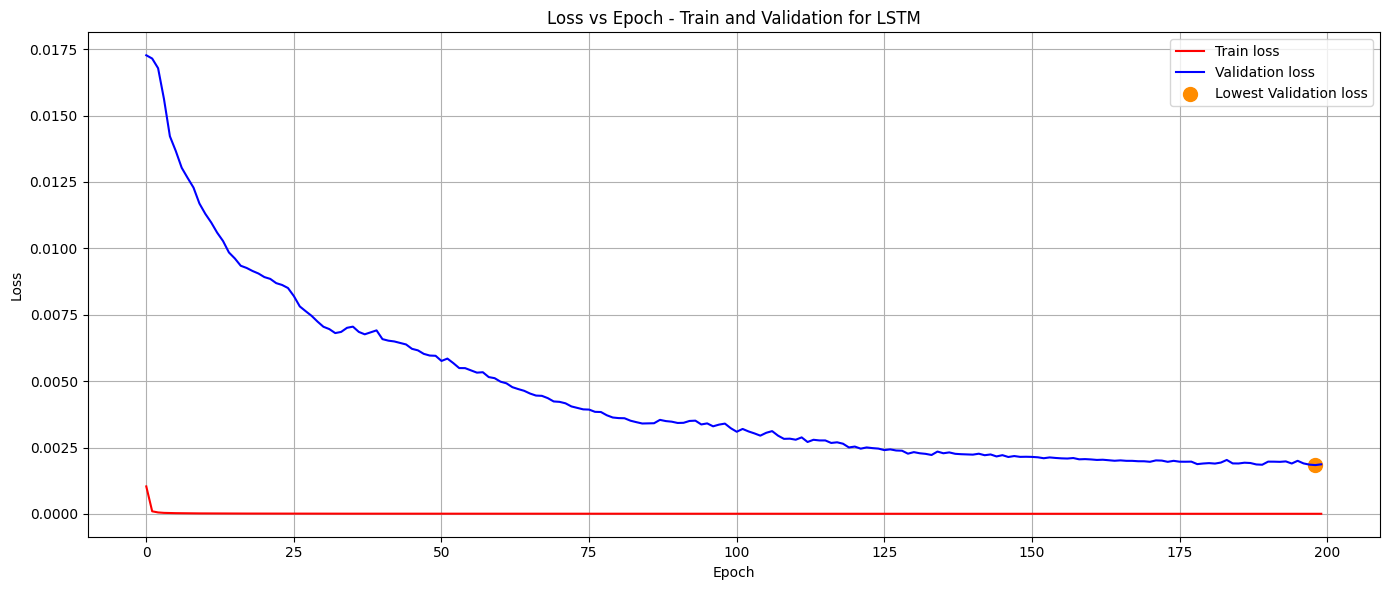

In [15]:
import matplotlib.pyplot as plt

# getting the best lost index
best_index = test_losses.index(min(test_losses))

# Plot Loss and Validation Loss
plt.figure(figsize=(14, 6))
plt.plot(losses, label="Train loss",color="red")
plt.plot(test_losses, label="Validation loss",color="blue")
plt.scatter(best_index, test_losses[best_index], label="Lowest Validation loss", color="darkorange",s=100)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch - Train and Validation for LSTM")
plt.tight_layout()
plt.grid(True)
plt.show()